<a href="https://colab.research.google.com/github/tahamokfi/covid_19/blob/master/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import sys
sns.set()
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# import data
## download CHR data
chr_2020 = pd.read_csv('https://www.countyhealthrankings.org/sites/default/files/media/document/analytic_data2020.csv', skiprows=1) #skip the first row
dict_data = pd.read_excel('https://www.countyhealthrankings.org/sites/default/files/media/document/DataDictionary_2020_1.xlsx')
## download US facts data
covid_death = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_deaths_usafacts.csv')
covid_case = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')

In [0]:
# select latest data
## death
latest_death_res = np.max(covid_death.columns[4:])
latest_death = covid_death[['countyFIPS',latest_death_res]][covid_death['countyFIPS']!=0] #exclude the state data
latest_death.columns = ['fipscode','covid_death']
## case
latest_case_res = np.max(covid_case.columns[4:])
latest_case = covid_case[['countyFIPS',latest_case_res]][covid_death['countyFIPS']!=0] #exclude the state data
latest_case.columns = ['fipscode','covid_case']

In [0]:
# join CHR to death and case statistics
join_death = pd.merge(chr_2020, latest_death, how='inner', on = 'fipscode')
join_all = pd.merge(join_death, latest_case, how='inner', on = 'fipscode')

In [0]:
# create the normalize rate using CHR population for each county
join_all['death_rate'] = join_all['covid_death']/join_all['v051_rawvalue']
join_all['case_rate'] = join_all['covid_case']/join_all['v051_rawvalue']

In [106]:
# quantile of COVID death
print (np.round(np.quantile(join_all.sort_values(['covid_death'])['covid_death'],[0.65,0.8,0.9,0.95,0.99,0.995,0.999]),1))

[  0.    1.    4.   12.   78.6 191.  771.8]


In [0]:
# function for running EDA and regression analysis
def eda_covid_chr(xvar ='v001_rawvalue', target_var = 'death_rate', filter_var = 'covid_death', min_prec = None, max_prec = None, r2_limit = 0.1):
  """
  This is the function for EDA and regression

  Parameters
  ----------
    xvar: The independent variable from CHR
    target: The dependent variable which can be death_rate or case_rate
    filter_var: The variable to filter data based on percentile
    min_prec: Minimum percentile of filter_var to subset the counties based on that
    min_prec: Maximum percentile of filter_var to subset the counties based on that
    r2_limit: Threshold for R2 in order to show the results

  Returns
  -------
    EDA report based on selected threshold

  Author: Taha Mokfi, mokfi.taha@gmail.com
  """
  # extract the desc from data dict
  meas_txt = dict_data[dict_data['Variable Name']==xvar]['Measure'].tolist()[0]
  desc_txt = dict_data[dict_data['Variable Name']==xvar]['Description'].tolist()[0]
  
  # filter data based on quantile of the filter_var 
  target_quant = np.quantile(join_all[filter_var],[min_prec, max_prec])
  dt_used = join_all[(join_all[filter_var] >= target_quant[0]) & (join_all[filter_var] <= target_quant[1])]
  
  # remove the rows with null values of var from CHR
  dt_used = dt_used[~dt_used[xvar].isna()]
  
  # if continue
  if dt_used.shape[0] > 21:
    # regression fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(dt_used[target_var], dt_used[xvar])
    r2_value = r_value**2

    # calculate the correlation
    corr_value = np.corrcoef(dt_used[target_var], dt_used[xvar])[0][1]

    if np.abs(r2_value) >= r2_limit:
      print ('\n','Variable measure is: ', meas_txt)
      print ('\n','Variable description is: ', desc_txt)
      print ('\n','Number of counties for this specific comparison: ', dt_used.shape[0])
      print ('\n','Correlation between '+ target_var + ' and ' + meas_txt + ' is: ', np.round(corr_value,2))
      print ('\n','R-squared between '+ target_var + ' and ' + meas_txt + ' is: ', np.round(r2_value,2))
      print ('\n','Sample data','\n',dt_used[[target_var,xvar]].head(3))
      # plot the relationship
      sns.jointplot(x=target_var, y=xvar, data=dt_used, kind="reg",color = 'blue')
      plt.show()
      return [xvar, meas_txt, target_var, corr_value,np.round(r2_value,2)] #return detailed info

In [0]:
# select all the columns from CHR with raw values
all_cols = join_all.columns[6:786]
col_raw_names = [i for i in all_cols if 'rawvalue' in i]


 Variable measure is:  Alcohol-impaired driving deaths raw value

 Variable description is:  Percentage of driving deaths with alcohol involvement.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Alcohol-impaired driving deaths raw value is:  -0.38

 R-squared between covid_death and Alcohol-impaired driving deaths raw value is:  0.15

 Sample data 
      covid_death  v134_rawvalue
98            15       0.226721
103           39       0.257039
106           20       0.282486


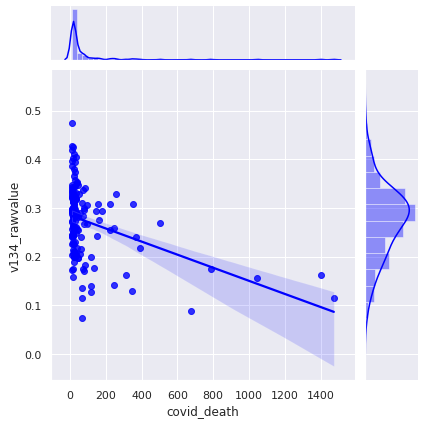


 Variable measure is:  Income inequality raw value

 Variable description is:  Ratio of household income at the 80th percentile to income at the 20th percentile.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Income inequality raw value is:  0.4

 R-squared between covid_death and Income inequality raw value is:  0.16

 Sample data 
      covid_death  v044_rawvalue
98            15       5.076507
103           39       4.481822
106           20       4.773894


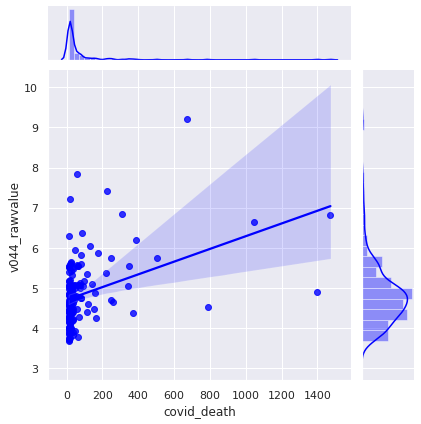


 Variable measure is:  Injury deaths raw value

 Variable description is:  Number of deaths due to injury per 100,000 population.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Injury deaths raw value is:  -0.32

 R-squared between covid_death and Injury deaths raw value is:  0.1

 Sample data 
      covid_death  v135_rawvalue
98            15     103.376932
103           39      75.113150
106           20      87.283698


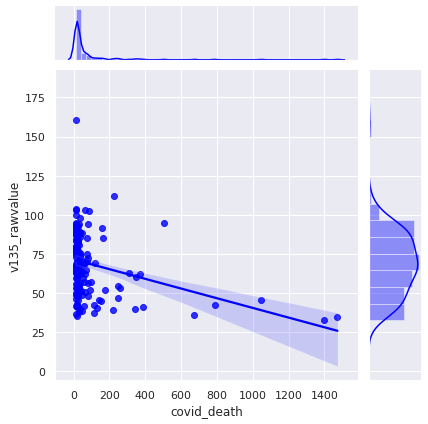


 Variable measure is:  Severe housing problems raw value

 Variable description is:  Percentage of households with at least 1 of 4 housing problems: overcrowding, high housing
costs, lack of kitchen facilities, or lack of plumbing facilities.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Severe housing problems raw value is:  0.55

 R-squared between covid_death and Severe housing problems raw value is:  0.3

 Sample data 
      covid_death  v136_rawvalue
98            15       0.253035
103           39       0.181831
106           20       0.195023


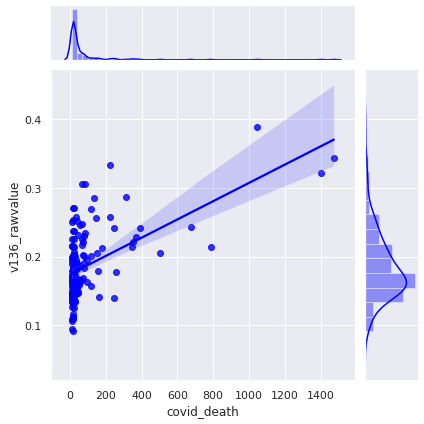


 Variable measure is:  Driving alone to work raw value

 Variable description is:  Percentage of the workforce that drives alone to work.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Driving alone to work raw value is:  -0.67

 R-squared between covid_death and Driving alone to work raw value is:  0.45

 Sample data 
      covid_death  v067_rawvalue
98            15       0.694835
103           39       0.762649
106           20       0.769229


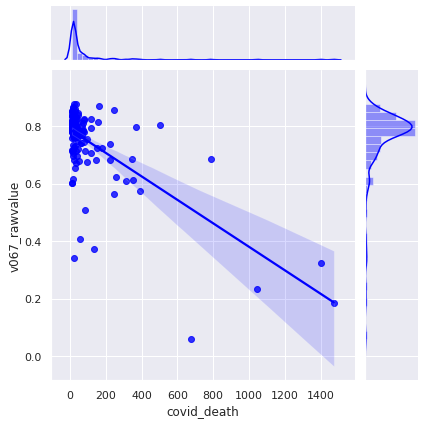


 Variable measure is:  Long commute - driving alone raw value

 Variable description is:  Among workers who commute in their car alone, the percentage that commute more than 30
minutes.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Long commute - driving alone raw value is:  0.35

 R-squared between covid_death and Long commute - driving alone raw value is:  0.12

 Sample data 
      covid_death  v137_rawvalue
98            15          0.158
103           39          0.376
106           20          0.349


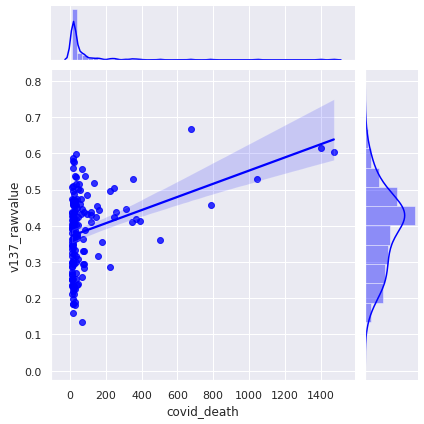


 Variable measure is:  HIV prevalence raw value

 Variable description is:  Number of people aged 13 years and older living with a diagnosis of human immunodeficiency
virus (HIV) infection per 100,000 population.

 Number of counties for this specific comparison:  148

 Correlation between covid_death and HIV prevalence raw value is:  0.37

 R-squared between covid_death and HIV prevalence raw value is:  0.14

 Sample data 
      covid_death  v061_rawvalue
98            15          113.7
103           39          309.1
106           20          281.4


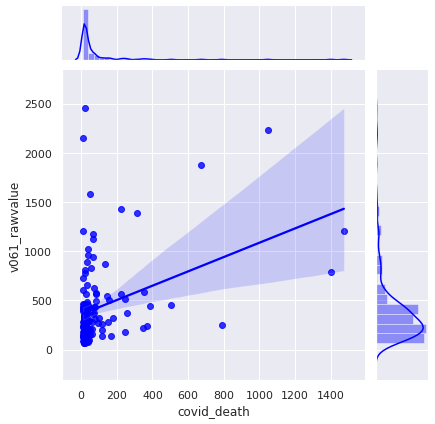


 Variable measure is:  Limited access to healthy foods raw value

 Variable description is:  Percentage of population who are low-income and do not live close to a grocery store.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Limited access to healthy foods raw value is:  -0.34

 R-squared between covid_death and Limited access to healthy foods raw value is:  0.12

 Sample data 
      covid_death  v083_rawvalue
98            15       0.138317
103           39       0.043995
106           20       0.076811


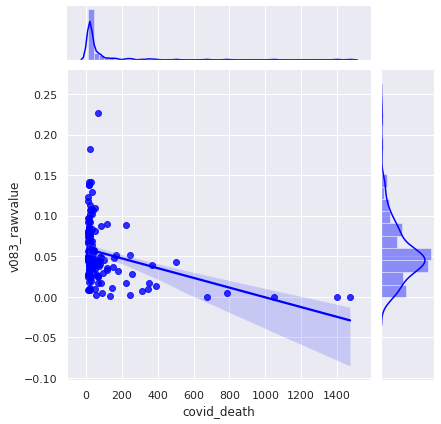


 Variable measure is:  Residential segregation - Black/White raw value

 Variable description is:  Index of dissimilarity where higher values indicate greater residential segregation between
Black and White county residents.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Residential segregation - Black/White raw value is:  0.35

 R-squared between covid_death and Residential segregation - Black/White raw value is:  0.12

 Sample data 
      covid_death  v141_rawvalue
98            15      50.178052
103           39      41.705638
106           20      41.525754


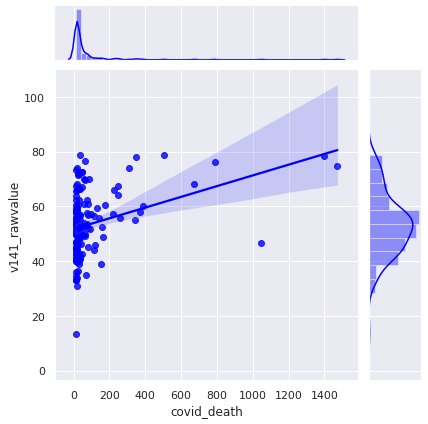


 Variable measure is:  Suicides raw value

 Variable description is:  Number of deaths due to suicide per 100,000 population (age-adjusted).

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Suicides raw value is:  -0.38

 R-squared between covid_death and Suicides raw value is:  0.14

 Sample data 
      covid_death  v161_rawvalue
98            15      25.127732
103           39      15.819633
106           20      18.571446


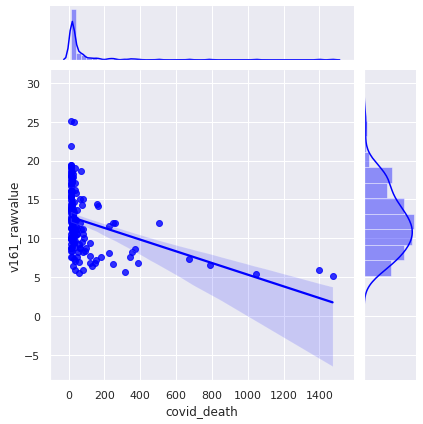


 Variable measure is:  Traffic volume raw value

 Variable description is:  Average traffic volume per meter of major roadways in the county.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Traffic volume raw value is:  0.78

 R-squared between covid_death and Traffic volume raw value is:  0.61

 Sample data 
      covid_death  v156_rawvalue
98            15     106.376388
103           39     885.046158
106           20    1864.797915


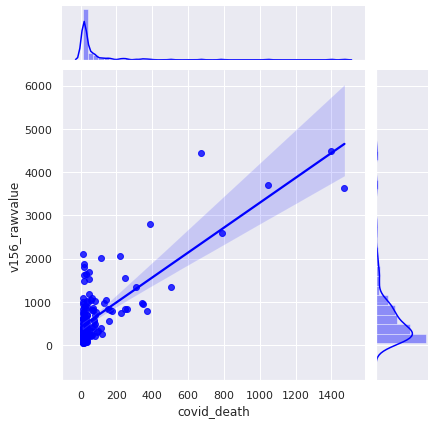


 Variable measure is:  Homeownership raw value

 Variable description is:  Percentage of occupied housing units that are owned.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Homeownership raw value is:  -0.41

 R-squared between covid_death and Homeownership raw value is:  0.17

 Sample data 
      covid_death  v153_rawvalue
98            15       0.605741
103           39       0.613580
106           20       0.623900


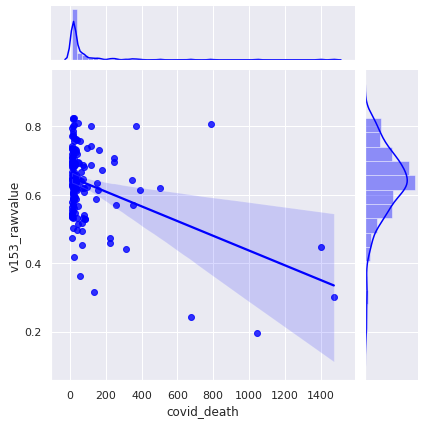


 Variable measure is:  Severe housing cost burden raw value

 Variable description is:  Percentage of households that spend 50% or more of their household income on housing.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and Severe housing cost burden raw value is:  0.55

 R-squared between covid_death and Severe housing cost burden raw value is:  0.3

 Sample data 
      covid_death  v154_rawvalue
98            15       0.168653
103           39       0.143364
106           20       0.156337


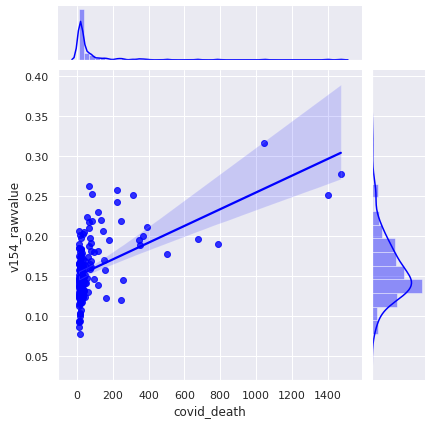


 Variable measure is:  % not proficient in English raw value

 Variable description is:  Percentage of population that is not proficient in English.

 Number of counties for this specific comparison:  160

 Correlation between covid_death and % not proficient in English raw value is:  0.43

 R-squared between covid_death and % not proficient in English raw value is:  0.18

 Sample data 
      covid_death  v059_rawvalue
98            15       0.021676
103           39       0.051506
106           20       0.042099


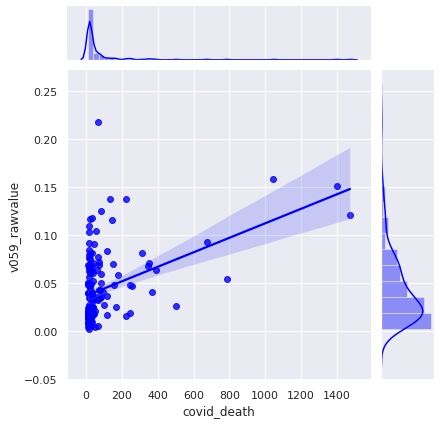


 Summary table: 


,variable_name,Desc,Dependent_var,Corr,R2
0,v156_rawvalue,Traffic volume raw value,covid_death,0.781123,0.61
1,v067_rawvalue,Driving alone to work raw value,covid_death,-0.673609,0.45
2,v136_rawvalue,Severe housing problems raw value,covid_death,0.548460,0.30
3,v154_rawvalue,Severe housing cost burden raw value,covid_death,0.548761,0.30
4,v059_rawvalue,% not proficient in English raw value,covid_death,0.429236,0.18
5,v153_rawvalue,Homeownership raw value,covid_death,-0.406870,0.17
6,v044_rawvalue,Income inequality raw value,covid_death,0.395855,0.16
7,v134_rawvalue,Alcohol-impaired driving deaths raw value,covid_death,-0.381636,0.15
8,v061_rawvalue,HIV prevalence raw value,covid_death,0.372433,0.14
9,v161_rawvalue,Suicides raw value,covid_death,-0.378064,0.14


In [107]:
# explore the covid death relationship with CHR variables
res_list = []
for i in col_raw_names:
  res_list.append(eda_covid_chr(xvar = i, target_var = 'covid_death',filter_var = 'covid_death', min_prec = 0.95, max_prec = 1, r2_limit = 0.1))
covid_death_tbl = pd.DataFrame([i for i in res_list if i != None])
covid_death_tbl.columns = ['variable_name','Desc','Dependent_var','Corr','R2']
covid_death_tbl = covid_death_tbl.sort_values('R2', ascending = False).reset_index(drop=True)
print ("\n","Summary table: ") 
covid_death_tbl


 Variable measure is:  Physical inactivity raw value

 Variable description is:  Percentage of adults age 20 and over reporting no leisure-time physical activity.

 Number of counties for this specific comparison:  160

 Correlation between death_rate and Physical inactivity raw value is:  0.38

 R-squared between death_rate and Physical inactivity raw value is:  0.14

 Sample data 
      death_rate  v070_rawvalue
98     0.000105          0.170
103    0.000009          0.204
106    0.000019          0.198


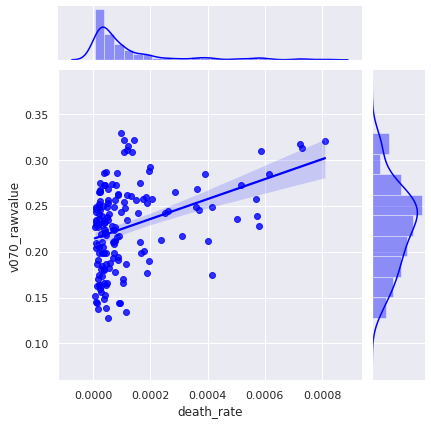


 Variable measure is:  Alcohol-impaired driving deaths raw value

 Variable description is:  Percentage of driving deaths with alcohol involvement.

 Number of counties for this specific comparison:  160

 Correlation between death_rate and Alcohol-impaired driving deaths raw value is:  -0.33

 R-squared between death_rate and Alcohol-impaired driving deaths raw value is:  0.11

 Sample data 
      death_rate  v134_rawvalue
98     0.000105       0.226721
103    0.000009       0.257039
106    0.000019       0.282486


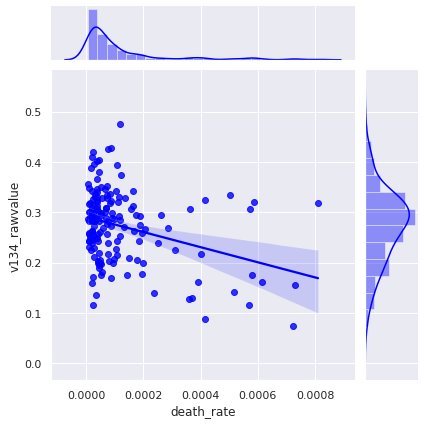


 Variable measure is:  Income inequality raw value

 Variable description is:  Ratio of household income at the 80th percentile to income at the 20th percentile.

 Number of counties for this specific comparison:  160

 Correlation between death_rate and Income inequality raw value is:  0.32

 R-squared between death_rate and Income inequality raw value is:  0.1

 Sample data 
      death_rate  v044_rawvalue
98     0.000105       5.076507
103    0.000009       4.481822
106    0.000019       4.773894


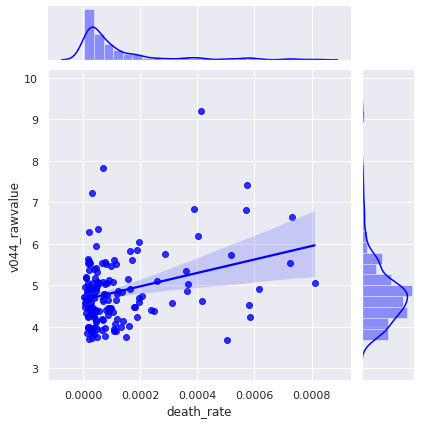


 Variable measure is:  Severe housing problems raw value

 Variable description is:  Percentage of households with at least 1 of 4 housing problems: overcrowding, high housing
costs, lack of kitchen facilities, or lack of plumbing facilities.

 Number of counties for this specific comparison:  160

 Correlation between death_rate and Severe housing problems raw value is:  0.33

 R-squared between death_rate and Severe housing problems raw value is:  0.11

 Sample data 
      death_rate  v136_rawvalue
98     0.000105       0.253035
103    0.000009       0.181831
106    0.000019       0.195023


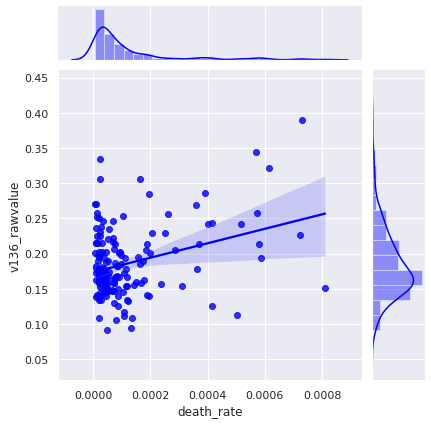


 Variable measure is:  Driving alone to work raw value

 Variable description is:  Percentage of the workforce that drives alone to work.

 Number of counties for this specific comparison:  160

 Correlation between death_rate and Driving alone to work raw value is:  -0.36

 R-squared between death_rate and Driving alone to work raw value is:  0.13

 Sample data 
      death_rate  v067_rawvalue
98     0.000105       0.694835
103    0.000009       0.762649
106    0.000019       0.769229


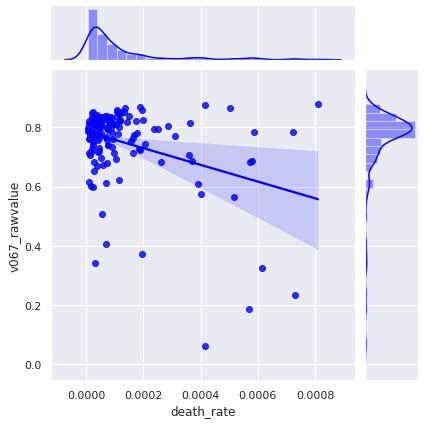


 Variable measure is:  Insufficient sleep raw value

 Variable description is:  Percentage of adults who report fewer than 7 hours of sleep on average.

 Number of counties for this specific comparison:  160

 Correlation between death_rate and Insufficient sleep raw value is:  0.41

 R-squared between death_rate and Insufficient sleep raw value is:  0.17

 Sample data 
      death_rate  v143_rawvalue
98     0.000105       0.306331
103    0.000009       0.342679
106    0.000019       0.309099


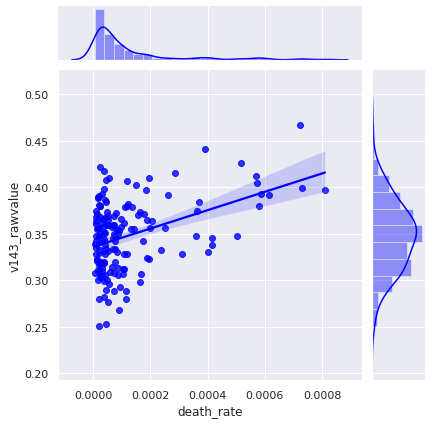


 Variable measure is:  Traffic volume raw value

 Variable description is:  Average traffic volume per meter of major roadways in the county.

 Number of counties for this specific comparison:  160

 Correlation between death_rate and Traffic volume raw value is:  0.4

 R-squared between death_rate and Traffic volume raw value is:  0.16

 Sample data 
      death_rate  v156_rawvalue
98     0.000105     106.376388
103    0.000009     885.046158
106    0.000019    1864.797915


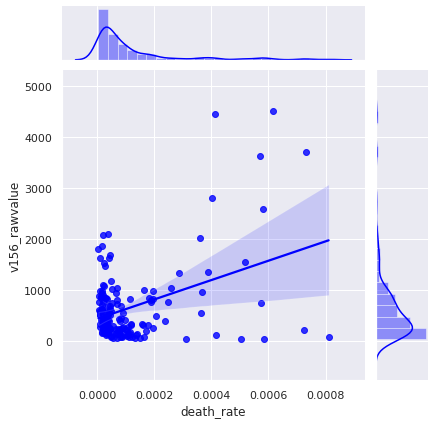


 Variable measure is:  Severe housing cost burden raw value

 Variable description is:  Percentage of households that spend 50% or more of their household income on housing.

 Number of counties for this specific comparison:  160

 Correlation between death_rate and Severe housing cost burden raw value is:  0.39

 R-squared between death_rate and Severe housing cost burden raw value is:  0.15

 Sample data 
      death_rate  v154_rawvalue
98     0.000105       0.168653
103    0.000009       0.143364
106    0.000019       0.156337


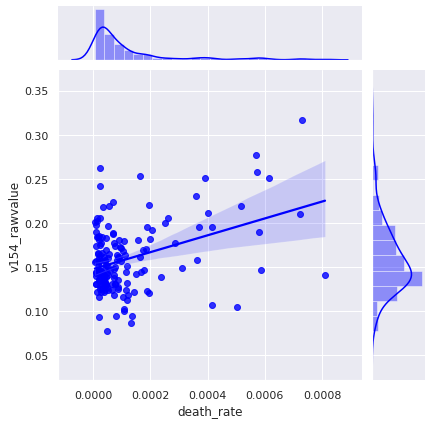


 Variable measure is:  % Non-Hispanic Black raw value

 Variable description is:  Percentage of population that is non-Hispanic Black or African American.

 Number of counties for this specific comparison:  160

 Correlation between death_rate and % Non-Hispanic Black raw value is:  0.33

 R-squared between death_rate and % Non-Hispanic Black raw value is:  0.11

 Sample data 
      death_rate  v054_rawvalue
98     0.000105       0.012509
103    0.000009       0.054661
106    0.000019       0.033892


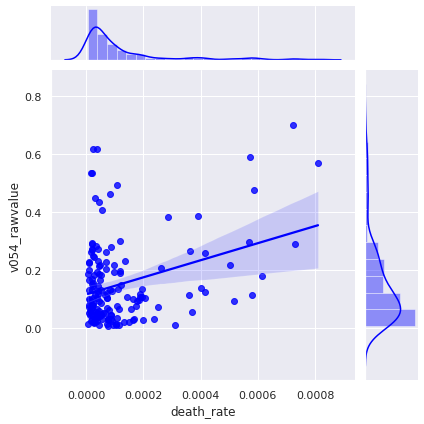


 Summary table: 


,variable_name,Desc,Dependent_var,Corr,R2
0,v143_rawvalue,Insufficient sleep raw value,death_rate,0.414616,0.17
1,v156_rawvalue,Traffic volume raw value,death_rate,0.402009,0.16
2,v154_rawvalue,Severe housing cost burden raw value,death_rate,0.392212,0.15
3,v070_rawvalue,Physical inactivity raw value,death_rate,0.376048,0.14
4,v067_rawvalue,Driving alone to work raw value,death_rate,-0.363098,0.13
5,v134_rawvalue,Alcohol-impaired driving deaths raw value,death_rate,-0.332160,0.11
6,v136_rawvalue,Severe housing problems raw value,death_rate,0.329723,0.11
7,v054_rawvalue,% Non-Hispanic Black raw value,death_rate,0.327000,0.11
8,v044_rawvalue,Income inequality raw value,death_rate,0.316555,0.10


In [108]:
# explore the covid death rate relationship with CHR variables
res_list = []
for i in col_raw_names:
  res_list.append(eda_covid_chr(xvar = i, target_var = 'death_rate',filter_var = 'covid_death', min_prec = 0.95, max_prec = 1, r2_limit = 0.1))
death_rate_tbl = pd.DataFrame([i for i in res_list if i != None])
death_rate_tbl.columns = ['variable_name','Desc','Dependent_var','Corr','R2']
death_rate_tbl = death_rate_tbl.sort_values('R2', ascending = False).reset_index(drop=True)
print ("\n","Summary table: ")
death_rate_tbl


 Variable measure is:  Access to exercise opportunities raw value

 Variable description is:  Percentage of population with adequate access to locations for physical activity.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Access to exercise opportunities raw value is:  0.33

 R-squared between covid_case and Access to exercise opportunities raw value is:  0.11

 Sample data 
      covid_case  v132_rawvalue
98          210       0.828762
103        1689       0.916026
106         512       0.878463


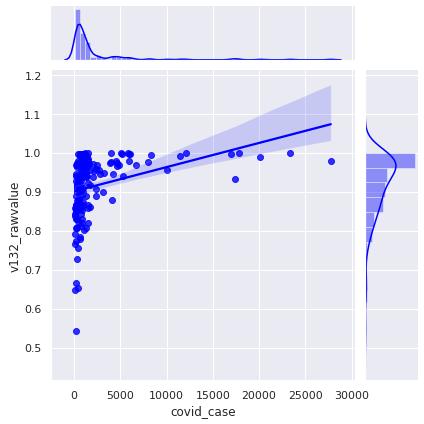


 Variable measure is:  Alcohol-impaired driving deaths raw value

 Variable description is:  Percentage of driving deaths with alcohol involvement.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Alcohol-impaired driving deaths raw value is:  -0.39

 R-squared between covid_case and Alcohol-impaired driving deaths raw value is:  0.16

 Sample data 
      covid_case  v134_rawvalue
98          210       0.226721
103        1689       0.257039
106         512       0.282486


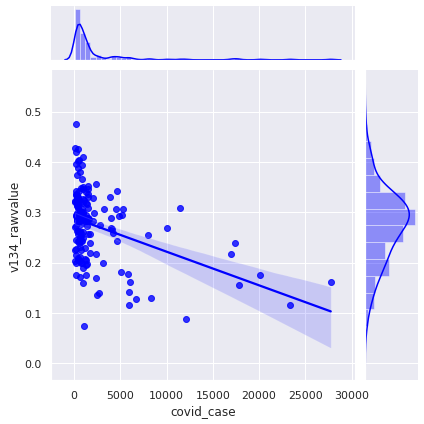


 Variable measure is:  Income inequality raw value

 Variable description is:  Ratio of household income at the 80th percentile to income at the 20th percentile.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Income inequality raw value is:  0.41

 R-squared between covid_case and Income inequality raw value is:  0.17

 Sample data 
      covid_case  v044_rawvalue
98          210       5.076507
103        1689       4.481822
106         512       4.773894


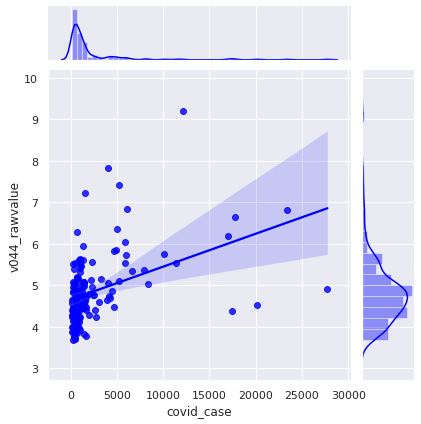


 Variable measure is:  Injury deaths raw value

 Variable description is:  Number of deaths due to injury per 100,000 population.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Injury deaths raw value is:  -0.36

 R-squared between covid_case and Injury deaths raw value is:  0.13

 Sample data 
      covid_case  v135_rawvalue
98          210     103.376932
103        1689      75.113150
106         512      87.283698


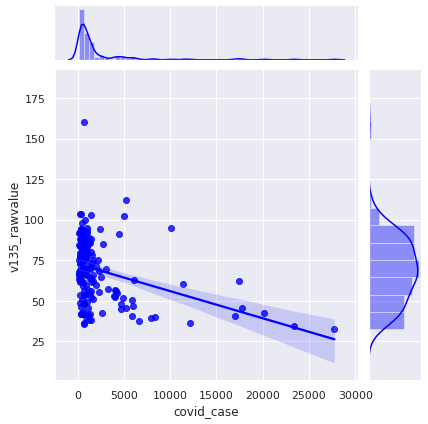


 Variable measure is:  Severe housing problems raw value

 Variable description is:  Percentage of households with at least 1 of 4 housing problems: overcrowding, high housing
costs, lack of kitchen facilities, or lack of plumbing facilities.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Severe housing problems raw value is:  0.6

 R-squared between covid_case and Severe housing problems raw value is:  0.36

 Sample data 
      covid_case  v136_rawvalue
98          210       0.253035
103        1689       0.181831
106         512       0.195023


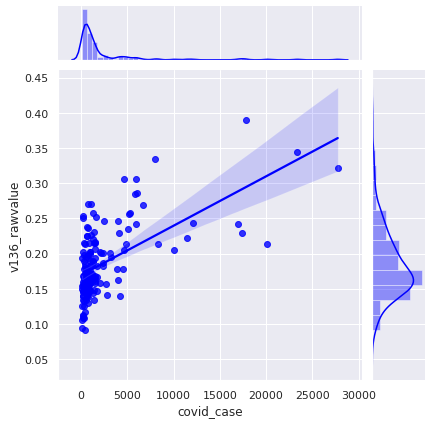


 Variable measure is:  Driving alone to work raw value

 Variable description is:  Percentage of the workforce that drives alone to work.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Driving alone to work raw value is:  -0.64

 R-squared between covid_case and Driving alone to work raw value is:  0.41

 Sample data 
      covid_case  v067_rawvalue
98          210       0.694835
103        1689       0.762649
106         512       0.769229


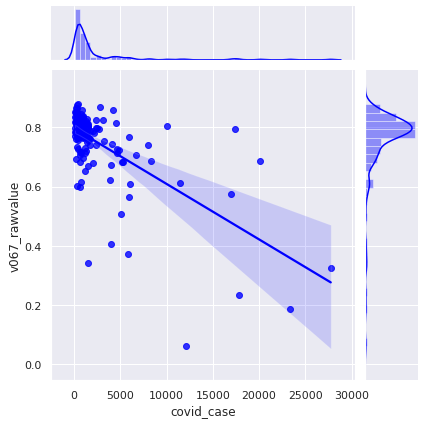


 Variable measure is:  Long commute - driving alone raw value

 Variable description is:  Among workers who commute in their car alone, the percentage that commute more than 30
minutes.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Long commute - driving alone raw value is:  0.38

 R-squared between covid_case and Long commute - driving alone raw value is:  0.14

 Sample data 
      covid_case  v137_rawvalue
98          210          0.158
103        1689          0.376
106         512          0.349


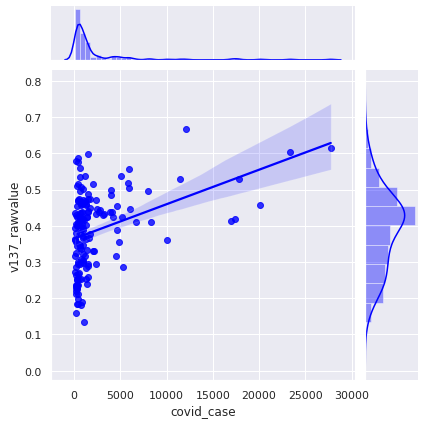


 Variable measure is:  Life expectancy raw value

 Variable description is:  Average number of years a person can expect to live.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Life expectancy raw value is:  0.33

 R-squared between covid_case and Life expectancy raw value is:  0.11

 Sample data 
      covid_case  v147_rawvalue
98          210      78.980006
103        1689      80.379855
106         512      79.566414


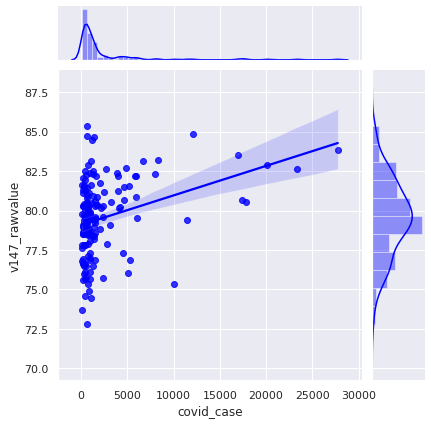


 Variable measure is:  HIV prevalence raw value

 Variable description is:  Number of people aged 13 years and older living with a diagnosis of human immunodeficiency
virus (HIV) infection per 100,000 population.

 Number of counties for this specific comparison:  148

 Correlation between covid_case and HIV prevalence raw value is:  0.34

 R-squared between covid_case and HIV prevalence raw value is:  0.12

 Sample data 
      covid_case  v061_rawvalue
98          210          113.7
103        1689          309.1
106         512          281.4


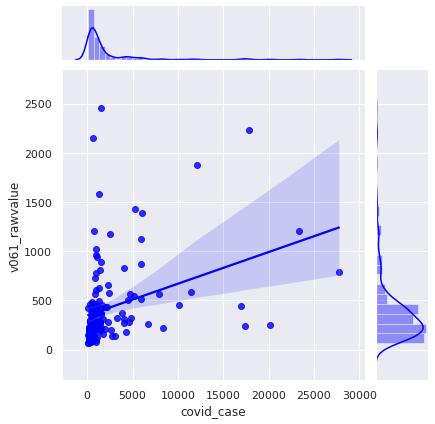


 Variable measure is:  Limited access to healthy foods raw value

 Variable description is:  Percentage of population who are low-income and do not live close to a grocery store.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Limited access to healthy foods raw value is:  -0.4

 R-squared between covid_case and Limited access to healthy foods raw value is:  0.16

 Sample data 
      covid_case  v083_rawvalue
98          210       0.138317
103        1689       0.043995
106         512       0.076811


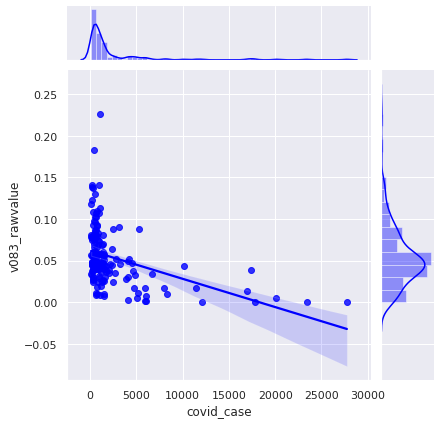


 Variable measure is:  Motor vehicle crash deaths raw value

 Variable description is:  Number of motor vehicle crash deaths per 100,000 population.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Motor vehicle crash deaths raw value is:  -0.34

 R-squared between covid_case and Motor vehicle crash deaths raw value is:  0.12

 Sample data 
      covid_case  v039_rawvalue
98          210      23.514505
103        1689      10.741381
106         512      11.480559


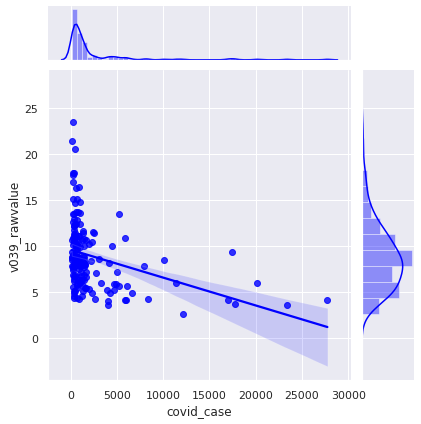


 Variable measure is:  Residential segregation - Black/White raw value

 Variable description is:  Index of dissimilarity where higher values indicate greater residential segregation between
Black and White county residents.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Residential segregation - Black/White raw value is:  0.39

 R-squared between covid_case and Residential segregation - Black/White raw value is:  0.15

 Sample data 
      covid_case  v141_rawvalue
98          210      50.178052
103        1689      41.705638
106         512      41.525754


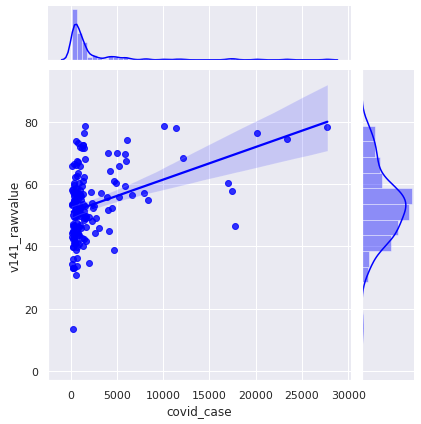


 Variable measure is:  Suicides raw value

 Variable description is:  Number of deaths due to suicide per 100,000 population (age-adjusted).

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Suicides raw value is:  -0.46

 R-squared between covid_case and Suicides raw value is:  0.21

 Sample data 
      covid_case  v161_rawvalue
98          210      25.127732
103        1689      15.819633
106         512      18.571446


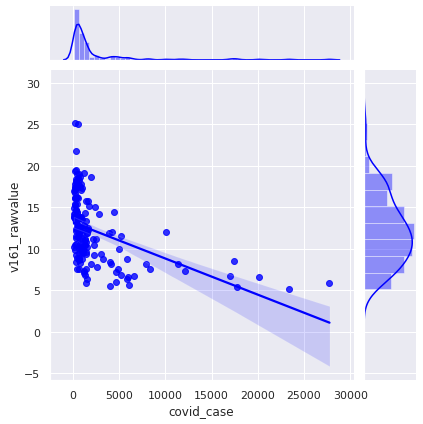


 Variable measure is:  Juvenile arrests raw value

 Variable description is:  Rate of delinquency cases per 1,000 juveniles

 Number of counties for this specific comparison:  136

 Correlation between covid_case and Juvenile arrests raw value is:  -0.38

 R-squared between covid_case and Juvenile arrests raw value is:  0.14

 Sample data 
      covid_case  v158_rawvalue
98          210      38.045113
103        1689      21.914849
106         512      47.690743


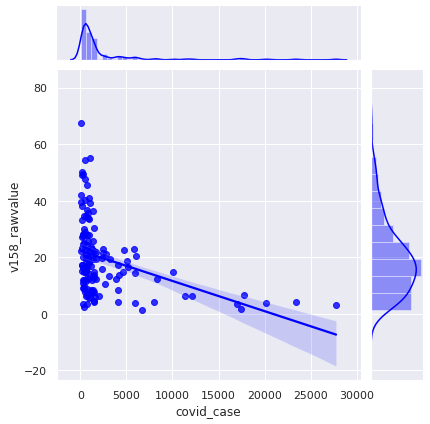


 Variable measure is:  Traffic volume raw value

 Variable description is:  Average traffic volume per meter of major roadways in the county.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Traffic volume raw value is:  0.77

 R-squared between covid_case and Traffic volume raw value is:  0.6

 Sample data 
      covid_case  v156_rawvalue
98          210     106.376388
103        1689     885.046158
106         512    1864.797915


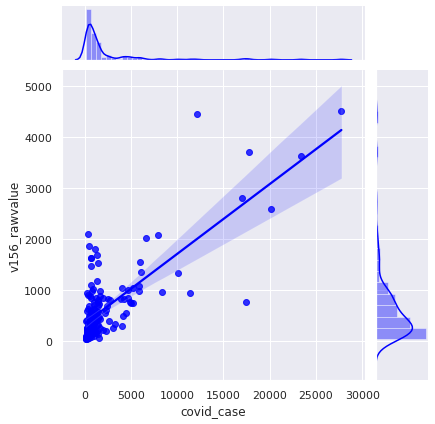


 Variable measure is:  Homeownership raw value

 Variable description is:  Percentage of occupied housing units that are owned.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Homeownership raw value is:  -0.36

 R-squared between covid_case and Homeownership raw value is:  0.13

 Sample data 
      covid_case  v153_rawvalue
98          210       0.605741
103        1689       0.613580
106         512       0.623900


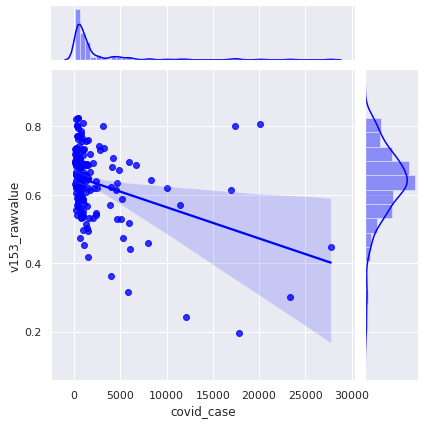


 Variable measure is:  Severe housing cost burden raw value

 Variable description is:  Percentage of households that spend 50% or more of their household income on housing.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Severe housing cost burden raw value is:  0.62

 R-squared between covid_case and Severe housing cost burden raw value is:  0.38

 Sample data 
      covid_case  v154_rawvalue
98          210       0.168653
103        1689       0.143364
106         512       0.156337


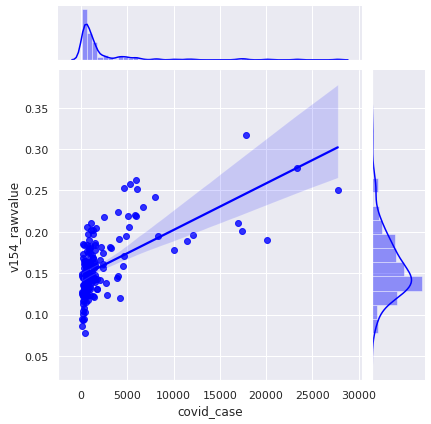


 Variable measure is:  Population raw value

 Variable description is:  Resident population.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and Population raw value is:  0.34

 R-squared between covid_case and Population raw value is:  0.12

 Sample data 
      covid_case  v051_rawvalue
98          210         142854
103        1689        4410824
106         512        1039073


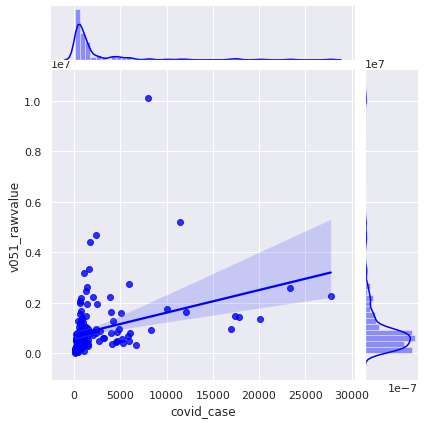


 Variable measure is:  % Non-Hispanic White raw value

 Variable description is:  Percentage of population that is non-Hispanic White.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and % Non-Hispanic White raw value is:  -0.32

 R-squared between covid_case and % Non-Hispanic White raw value is:  0.1

 Sample data 
      covid_case  v126_rawvalue
98          210       0.539908
103        1689       0.549021
106         512       0.514314


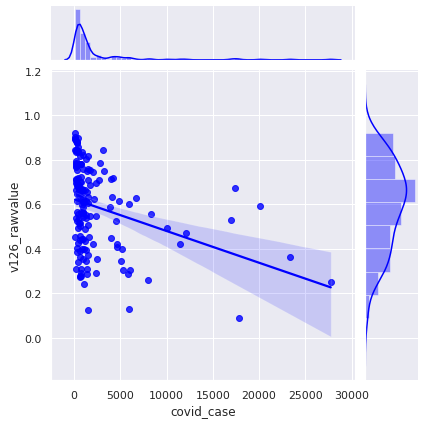


 Variable measure is:  % not proficient in English raw value

 Variable description is:  Percentage of population that is not proficient in English.

 Number of counties for this specific comparison:  160

 Correlation between covid_case and % not proficient in English raw value is:  0.49

 R-squared between covid_case and % not proficient in English raw value is:  0.24

 Sample data 
      covid_case  v059_rawvalue
98          210       0.021676
103        1689       0.051506
106         512       0.042099


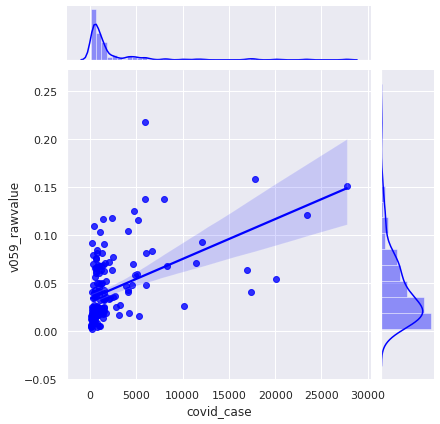


 Summary table: 


,variable_name,Desc,Dependent_var,Corr,R2
0,v156_rawvalue,Traffic volume raw value,covid_case,0.772478,0.60
1,v067_rawvalue,Driving alone to work raw value,covid_case,-0.643591,0.41
2,v154_rawvalue,Severe housing cost burden raw value,covid_case,0.616145,0.38
3,v136_rawvalue,Severe housing problems raw value,covid_case,0.601714,0.36
4,v059_rawvalue,% not proficient in English raw value,covid_case,0.491698,0.24
5,v161_rawvalue,Suicides raw value,covid_case,-0.456254,0.21
6,v044_rawvalue,Income inequality raw value,covid_case,0.413086,0.17
7,v083_rawvalue,Limited access to healthy foods raw value,covid_case,-0.401501,0.16
8,v134_rawvalue,Alcohol-impaired driving deaths raw value,covid_case,-0.394613,0.16
9,v141_rawvalue,Residential segregation - Black/White raw value,covid_case,0.391073,0.15


In [109]:
# explore the covid case relationship with CHR variables
res_list = []
for i in col_raw_names:
  res_list.append(eda_covid_chr(xvar = i, target_var = 'covid_case',filter_var = 'covid_death', min_prec = 0.95, max_prec = 1, r2_limit = 0.1))
covid_case_tbl = pd.DataFrame([i for i in res_list if i != None])
covid_case_tbl.columns = ['variable_name','Desc','Dependent_var','Corr','R2']
covid_case_tbl = covid_case_tbl.sort_values('R2', ascending = False).reset_index(drop=True)
print ("\n","Summary table: ")
covid_case_tbl


 Variable measure is:  Physical inactivity raw value

 Variable description is:  Percentage of adults age 20 and over reporting no leisure-time physical activity.

 Number of counties for this specific comparison:  160

 Correlation between case_rate and Physical inactivity raw value is:  0.32

 R-squared between case_rate and Physical inactivity raw value is:  0.1

 Sample data 
      case_rate  v070_rawvalue
98    0.001470          0.170
103   0.000383          0.204
106   0.000493          0.198


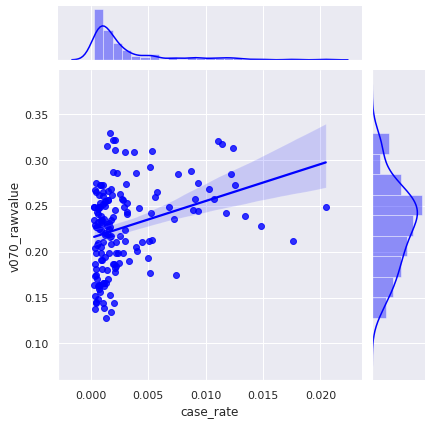


 Variable measure is:  Alcohol-impaired driving deaths raw value

 Variable description is:  Percentage of driving deaths with alcohol involvement.

 Number of counties for this specific comparison:  160

 Correlation between case_rate and Alcohol-impaired driving deaths raw value is:  -0.35

 R-squared between case_rate and Alcohol-impaired driving deaths raw value is:  0.12

 Sample data 
      case_rate  v134_rawvalue
98    0.001470       0.226721
103   0.000383       0.257039
106   0.000493       0.282486


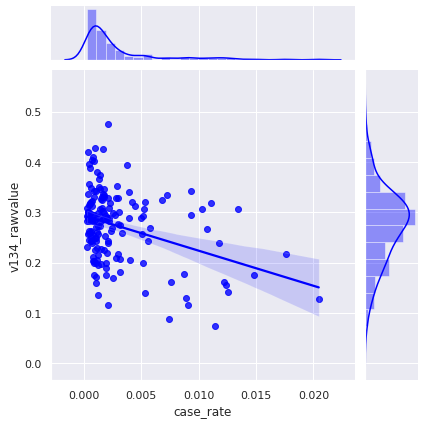


 Variable measure is:  Income inequality raw value

 Variable description is:  Ratio of household income at the 80th percentile to income at the 20th percentile.

 Number of counties for this specific comparison:  160

 Correlation between case_rate and Income inequality raw value is:  0.38

 R-squared between case_rate and Income inequality raw value is:  0.14

 Sample data 
      case_rate  v044_rawvalue
98    0.001470       5.076507
103   0.000383       4.481822
106   0.000493       4.773894


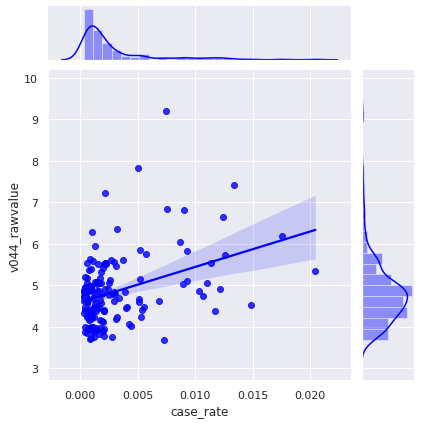


 Variable measure is:  Severe housing problems raw value

 Variable description is:  Percentage of households with at least 1 of 4 housing problems: overcrowding, high housing
costs, lack of kitchen facilities, or lack of plumbing facilities.

 Number of counties for this specific comparison:  160

 Correlation between case_rate and Severe housing problems raw value is:  0.44

 R-squared between case_rate and Severe housing problems raw value is:  0.19

 Sample data 
      case_rate  v136_rawvalue
98    0.001470       0.253035
103   0.000383       0.181831
106   0.000493       0.195023


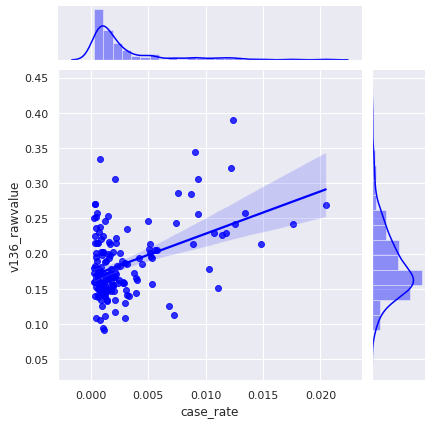


 Variable measure is:  Driving alone to work raw value

 Variable description is:  Percentage of the workforce that drives alone to work.

 Number of counties for this specific comparison:  160

 Correlation between case_rate and Driving alone to work raw value is:  -0.4

 R-squared between case_rate and Driving alone to work raw value is:  0.16

 Sample data 
      case_rate  v067_rawvalue
98    0.001470       0.694835
103   0.000383       0.762649
106   0.000493       0.769229


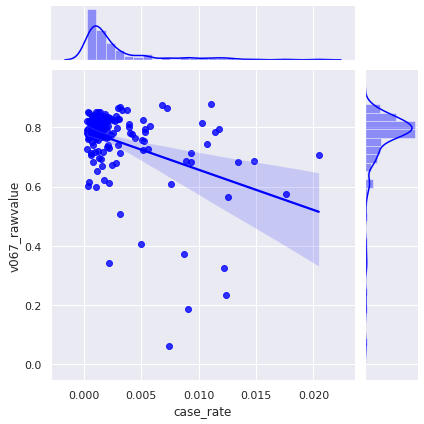


 Variable measure is:  Insufficient sleep raw value

 Variable description is:  Percentage of adults who report fewer than 7 hours of sleep on average.

 Number of counties for this specific comparison:  160

 Correlation between case_rate and Insufficient sleep raw value is:  0.39

 R-squared between case_rate and Insufficient sleep raw value is:  0.15

 Sample data 
      case_rate  v143_rawvalue
98    0.001470       0.306331
103   0.000383       0.342679
106   0.000493       0.309099


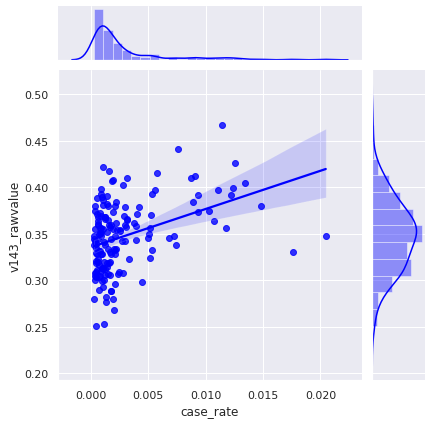


 Variable measure is:  Suicides raw value

 Variable description is:  Number of deaths due to suicide per 100,000 population (age-adjusted).

 Number of counties for this specific comparison:  160

 Correlation between case_rate and Suicides raw value is:  -0.43

 R-squared between case_rate and Suicides raw value is:  0.18

 Sample data 
      case_rate  v161_rawvalue
98    0.001470      25.127732
103   0.000383      15.819633
106   0.000493      18.571446


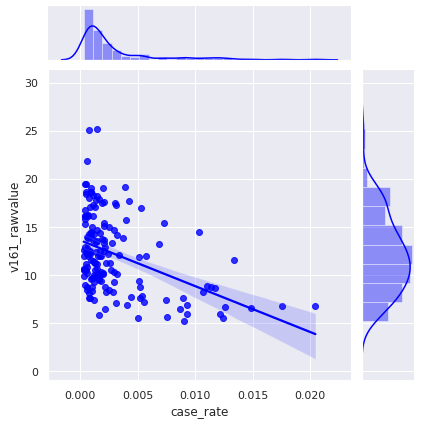


 Variable measure is:  Traffic volume raw value

 Variable description is:  Average traffic volume per meter of major roadways in the county.

 Number of counties for this specific comparison:  160

 Correlation between case_rate and Traffic volume raw value is:  0.46

 R-squared between case_rate and Traffic volume raw value is:  0.21

 Sample data 
      case_rate  v156_rawvalue
98    0.001470     106.376388
103   0.000383     885.046158
106   0.000493    1864.797915


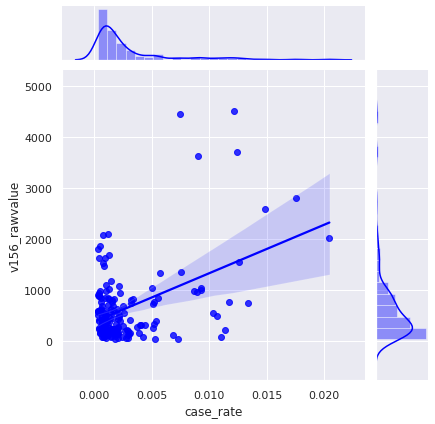


 Variable measure is:  Severe housing cost burden raw value

 Variable description is:  Percentage of households that spend 50% or more of their household income on housing.

 Number of counties for this specific comparison:  160

 Correlation between case_rate and Severe housing cost burden raw value is:  0.52

 R-squared between case_rate and Severe housing cost burden raw value is:  0.27

 Sample data 
      case_rate  v154_rawvalue
98    0.001470       0.168653
103   0.000383       0.143364
106   0.000493       0.156337


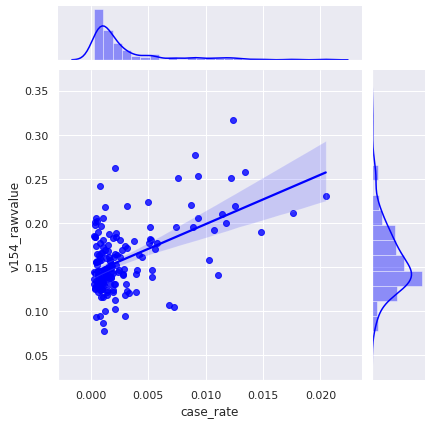


 Summary table: 


,variable_name,Desc,Dependent_var,Corr,R2
0,v154_rawvalue,Severe housing cost burden raw value,case_rate,0.523334,0.27
1,v156_rawvalue,Traffic volume raw value,case_rate,0.457216,0.21
2,v136_rawvalue,Severe housing problems raw value,case_rate,0.440100,0.19
3,v161_rawvalue,Suicides raw value,case_rate,-0.426050,0.18
4,v067_rawvalue,Driving alone to work raw value,case_rate,-0.397645,0.16
5,v143_rawvalue,Insufficient sleep raw value,case_rate,0.393465,0.15
6,v044_rawvalue,Income inequality raw value,case_rate,0.378932,0.14
7,v134_rawvalue,Alcohol-impaired driving deaths raw value,case_rate,-0.351239,0.12
8,v070_rawvalue,Physical inactivity raw value,case_rate,0.317333,0.10


In [110]:
# explore the covid case rate relationship with CHR variables
res_list = []
for i in col_raw_names:
  res_list.append(eda_covid_chr(xvar = i, target_var = 'case_rate',filter_var = 'covid_death', min_prec = 0.95, max_prec = 1, r2_limit = 0.1))
case_rate_tbl = pd.DataFrame([i for i in res_list if i != None])
case_rate_tbl.columns = ['variable_name','Desc','Dependent_var','Corr','R2']
case_rate_tbl = case_rate_tbl.sort_values('R2', ascending = False).reset_index(drop=True)
print ("\n","Summary table: ")
case_rate_tbl


 Variable measure is:  Diabetes prevalence raw value

 Variable description is:  Percentage of adults aged 20 and above with diagnosed diabetes.

 Number of counties for this specific comparison:  337

 Correlation between death_rate and Diabetes prevalence raw value is:  0.21

 R-squared between death_rate and Diabetes prevalence raw value is:  0.04

 Sample data 
     death_rate  v060_rawvalue
8     0.000238          0.199
27    0.000039          0.157
36    0.000009          0.129


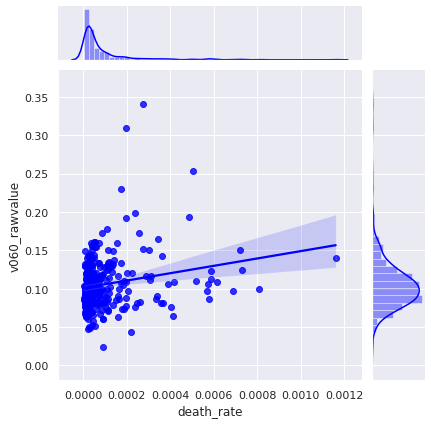

['v060_rawvalue',
 'Diabetes prevalence raw value',
 'death_rate',
 0.2102463887017764,
 0.04]

In [104]:
eda_covid_chr(xvar = 'v060_rawvalue', target_var = 'death_rate',filter_var = 'covid_death', min_prec = 0.90, max_prec = 1, r2_limit = 0.001)